### Library

In [1]:
import os
import time
import random
import timm
import torch
import cv2
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [2]:
def random_seed(SEED=42):
    # SEED = 42 # default
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True

random_seed()

### Load Data

In [3]:
train_label_path = "../../data/train.csv"
meta_data_path = "../../data/meta.csv"

train_label = pd.read_csv(train_label_path)
meta_data = pd.read_csv(meta_data_path)
train_labels = pd.merge(train_label, meta_data, on="target", how="left")

train_labels = train_labels[['ID', 'class_name', 'target']]
train_labels

ID                      class_name  target
0     002f99746285dfdd.jpg      vehicle_registration_plate      16
1     008ccd231e1fea5d.jpg            payment_confirmation      10
2     008f5911bfda7695.jpg            payment_confirmation      10
3     009235e4c9c07af5.jpg                       diagnosis       4
4     00b2f44967580c74.jpg      vehicle_registration_plate      16
...                    ...                             ...     ...
1565  fed9e9ec4a77bc06.jpg                       diagnosis       4
1566  feeade617aa68c45.jpg  medical_outpatient_certificate       7
1567  ff51dd281a8423f1.jpg          pharmaceutical_receipt      11
1568  ff8a6a251ce51c95.jpg                  driver_lisence       5
1569  ffc22136f958deb1.jpg                        passport       9

[1570 rows x 3 columns]

In [4]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570 entries, 0 to 1569
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          1570 non-null   object
 1   class_name  1570 non-null   object
 2   target      1570 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 36.9+ KB


In [5]:
class Image_Dataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # train용 (ID, target)
        if self.df.shape[1] == 2:
            name, target = self.df[idx]
        # test용 (ID만 있음)
        else:
            name = self.df[idx][0]
            target = -1  # placeholder

        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_path = '../../data/train/'
train_dataset = Image_Dataset(csv=f"{train_label_path}", path=f"{train_path}")

print(len(train_dataset))

1570


### EDA

In [45]:
# Count_plot
def count_plot(df, col, figsize=(10, 6), palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel='Count'):
    plt.figure(figsize=figsize)
    sns.countplot(data=df, x=col, palette=palette)
    plt.title(title if title else f'{col} Count')
    plt.xticks(rotation=rotation)
    plt.xlabel(xlabel if xlabel is not None else col)
    plt.ylabel(ylabel)
    plt.show()

# hist plot
def hist_plot(df1, col, df2=None, figsize=(8, 6), bins=30, alpha=0.6, 
              color1='skyblue', color2='salmon', label1=None, label2=None, 
              title=None, density=False):
    plt.figure(figsize=figsize)
    
    stat_mode = 'density' if density else 'count'

    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, 
                 stat=stat_mode, label=label1 if label1 else ('Group 1' if df2 is not None else None))
    
    if df2 is not None:
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, 
                     stat=stat_mode, label=label2 if label2 else 'Group 2')
        plt.legend()

    plt.title(title if title else f'{col} Distribution ({"Density" if density else "Count"} Histogram + KDE)')
    plt.xlabel(col)
    plt.ylabel("Density" if density else "Count")
    plt.show()

# bar plot    
def bar_plot(df, x_col, y_col, figsize=(10, 6), hue=None, palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel=None):
     plt.figure(figsize=figsize)
     
     if hue: # hue 지정
        sns.barplot(x=x_col, y=y_col, hue=hue, data=df, palette=palette)
     else: # hue 지정 X
        sns.barplot(x=x_col, y=y_col, data=df, palette=palette)

     plt.xticks(rotation=rotation)
     plt.title(title)
     plt.xlabel(xlabel)
     plt.ylabel(ylabel)
     plt.show()

# heatmap
def heat_map(df, target_col=None, figsize=(8, 10), threshold=0, cmap='Reds', method='pearson', annot_kws=None, return_data=False):
        df = df.select_dtypes(include=['number'])
        
        if annot_kws is None:
            annot_kws = {"size": 10}

        if target_col is not None:
            corr_series = df.corr(method=method)[target_col].drop(target_col)
            corr_filtered = corr_series[abs(corr_series) >= threshold].sort_values(ascending=False)

            plt.figure(figsize=figsize)
            sns.heatmap(corr_filtered.to_frame(name='Correlation'), annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation with {target_col}', fontsize=14)
            plt.show()

            corr_df = corr_filtered.reset_index()
            corr_df.columns = ['Variable', 'Correlation']

            if return_data:
                return corr_df

        else:
            corr_matrix = df.corr(method=method) # 전체 변수 간 상관계수

            plt.figure(figsize=figsize)
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation Matrix (All Variables)', fontsize=14)
            plt.show()

            if return_data:
                return corr_matrix

#### **Train Data**

- Class_Imbalance

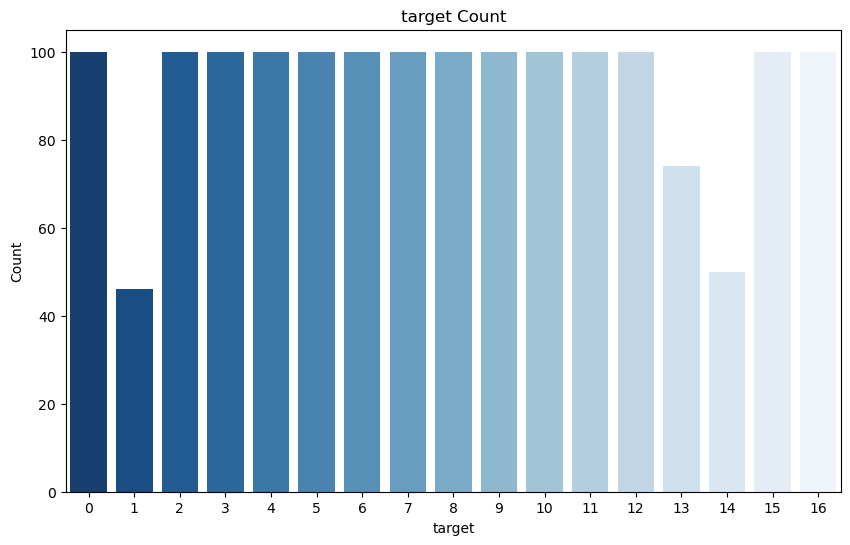

In [8]:
# Class check
count_plot(df=train_labels, col='target')

In [9]:
class_imbalance = train_label[train_label['target'].isin([1, 13, 14])]['target'].unique().tolist()
class_imbalance

# imbalance_col = class_imbalance['class_name'].unique().tolist()
# imbalance_col

[14, 13, 1]

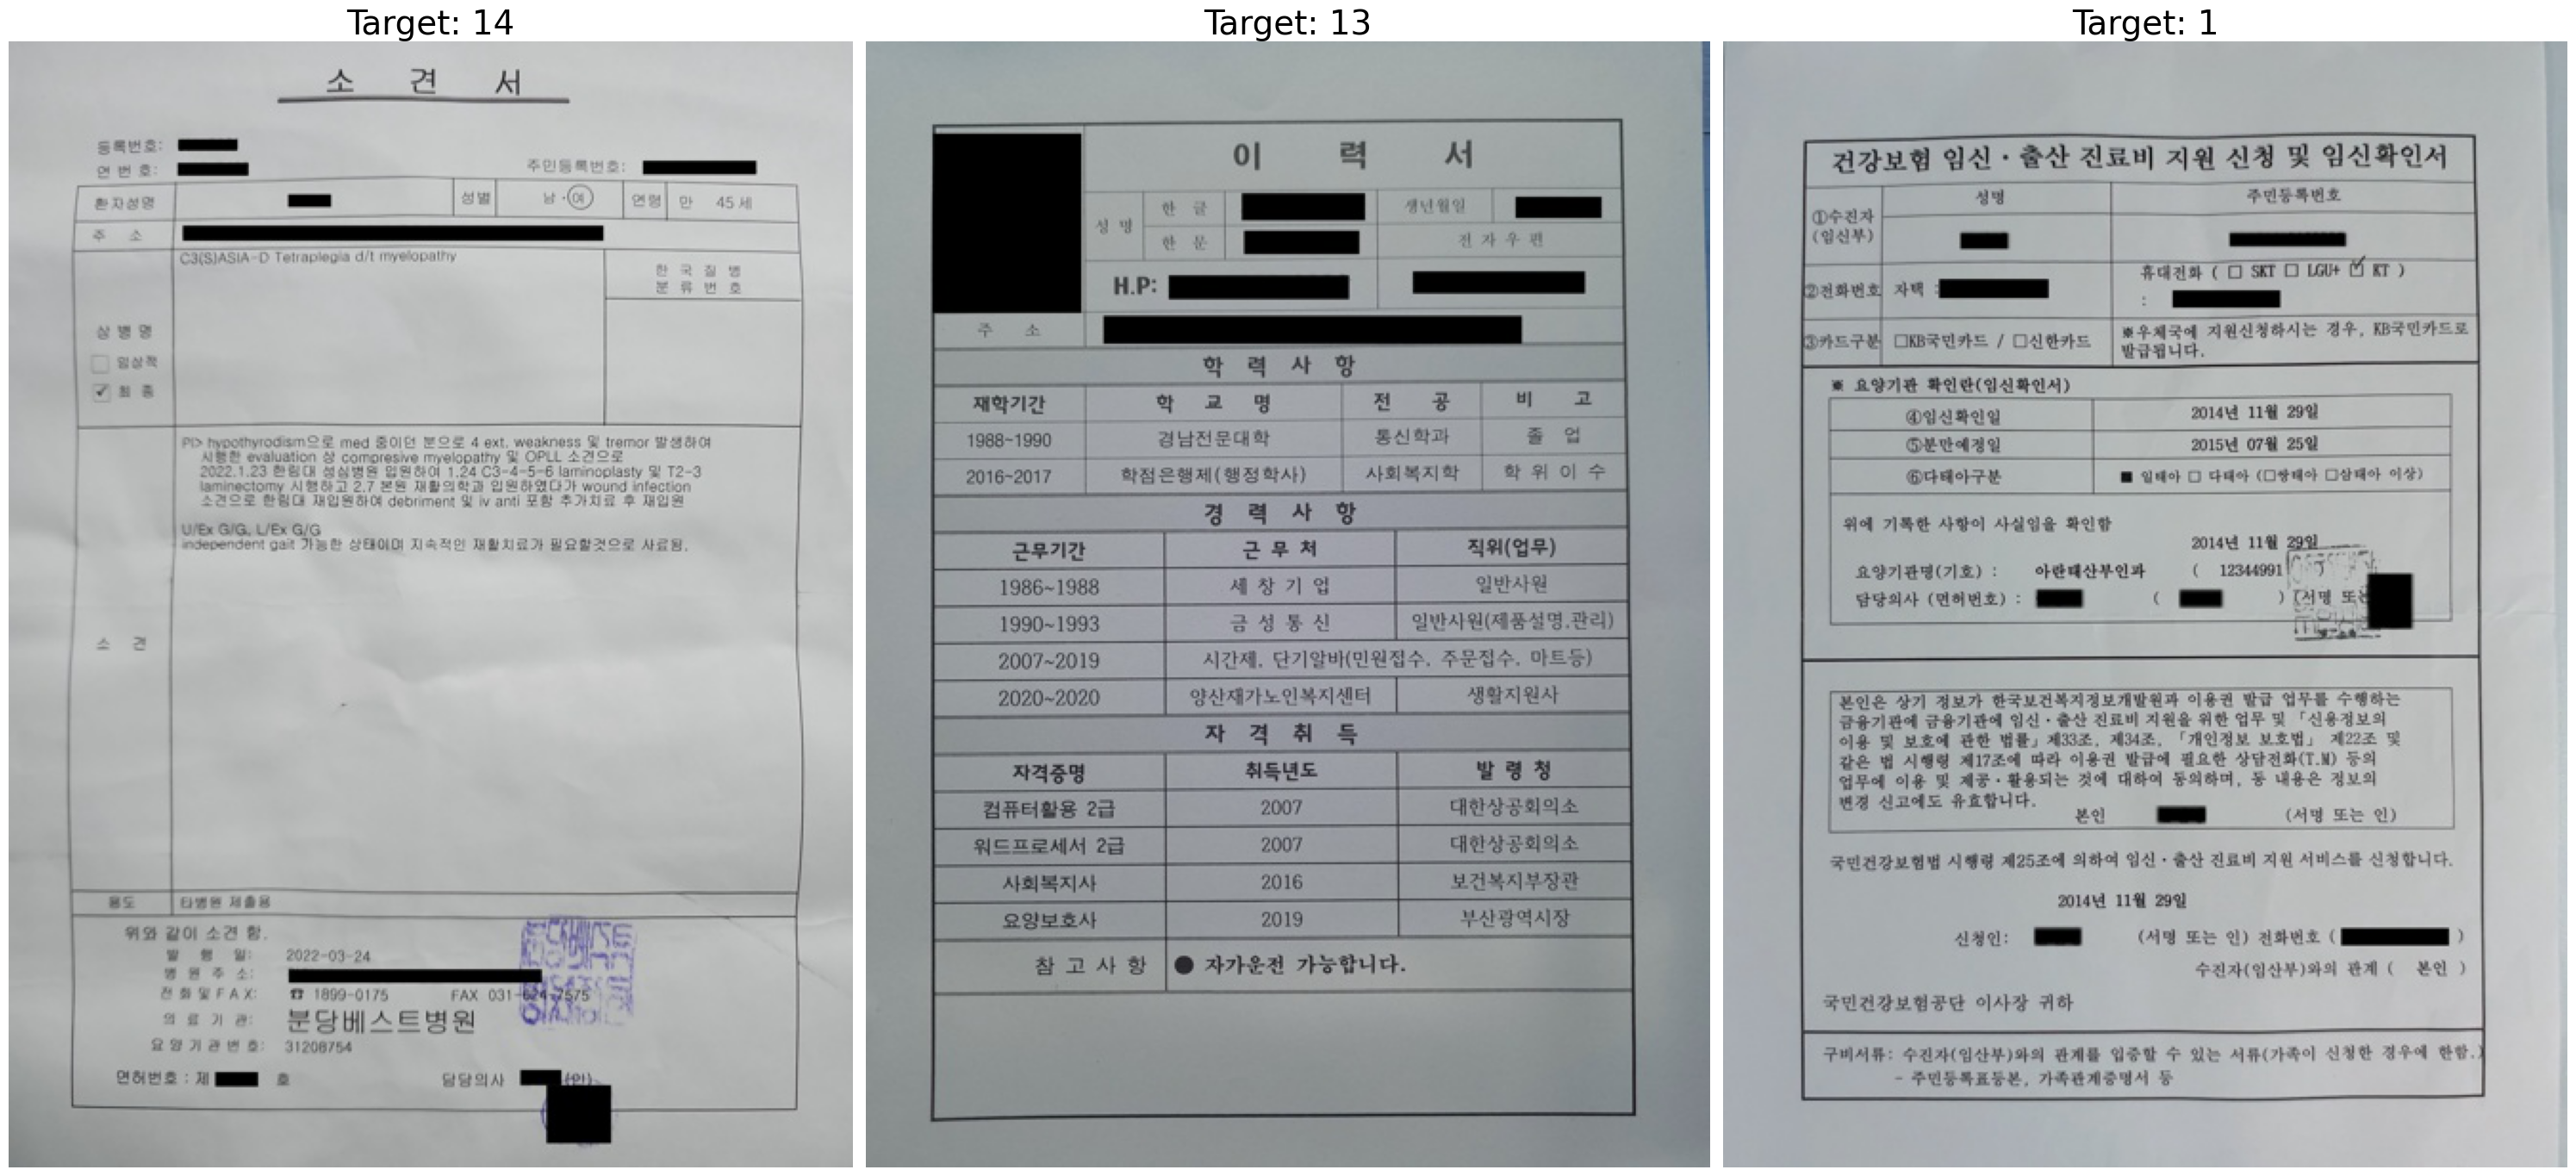

In [10]:
fig, axes = plt.subplots(1, len(class_imbalance), figsize=(10 * len(class_imbalance), 15))

for ax, target in zip(axes, class_imbalance):
    subset = train_label[train_label['target'] == target]
    sample_row = subset.sample(1).iloc[0]
    img_name = sample_row.iloc[0]  # ID Column
    img_path = os.path.join(train_path, img_name)
    
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Target: {sample_row['target']}", fontsize=28)
    ax.axis('off')

plt.tight_layout()
plt.show()

- Blur Check

In [11]:
variances = []

for idx, row in tqdm(train_label.iterrows(), total=len(train_label)):
    img_name = row.iloc[0]  # ID Column
    img_path = os.path.join(train_path, img_name)
    
    img_cv = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_cv is None:
        print(f"이미지 로드 실패: {img_path}")
        continue
    
    variance = cv2.Laplacian(img_cv, cv2.CV_64F).var()
    variances.append({
        "ID": img_name,
        "target": row["target"],
        "variance": variance # 값이 클수록 선명함
    })

blur = pd.DataFrame(variances)
blur

100%|██████████| 1570/1570 [00:02<00:00, 628.44it/s]


ID  target     variance
0     002f99746285dfdd.jpg      16  4461.719775
1     008ccd231e1fea5d.jpg      10  1630.437757
2     008f5911bfda7695.jpg      10  3522.353811
3     009235e4c9c07af5.jpg       4  1140.816877
4     00b2f44967580c74.jpg      16  1590.176746
...                    ...     ...          ...
1565  fed9e9ec4a77bc06.jpg       4  1478.417648
1566  feeade617aa68c45.jpg       7  1054.485550
1567  ff51dd281a8423f1.jpg      11  2019.669529
1568  ff8a6a251ce51c95.jpg       5   941.559549
1569  ffc22136f958deb1.jpg       9  2893.576158

[1570 rows x 3 columns]

In [12]:
blur[['variance']].describe()

variance
count  1570.000000
mean   1358.170567
std     822.036554
min      70.042379
25%     767.158727
50%    1199.573751
75%    1795.379881
max    4955.884694

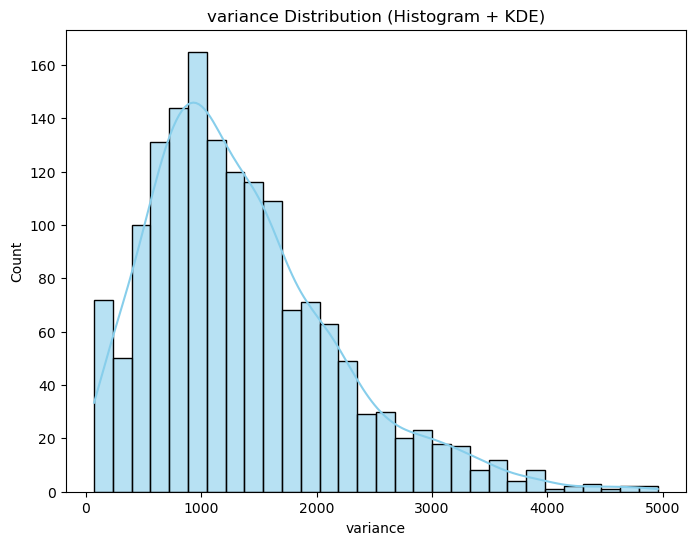

흐릿한 이미지 샘플 개수: 6


In [13]:
threshold = 100
blurry_samples = blur[blur['variance'] < threshold]

hist_plot(df1=blur, col='variance')
print(f"흐릿한 이미지 샘플 개수: {len(blurry_samples)}")

In [48]:
def show_sample_image(df, path, analysis_col, n_samples=3):
    sampled = df.sample(n=n_samples).reset_index(drop=True)
    
    fig, axes = plt.subplots(1, n_samples, figsize=(8 * n_samples, 10))
    if n_samples == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, sampled.iterrows()):
        img_path = os.path.join(path, row['ID'])
        img = Image.open(img_path)
        target_text = f"{row['target']}" if 'target' in row else "N/A"
        ax.imshow(img)
        ax.set_title(f"Target: {target_text} | {analysis_col}: {row[analysis_col]:.1f}", fontsize=18)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

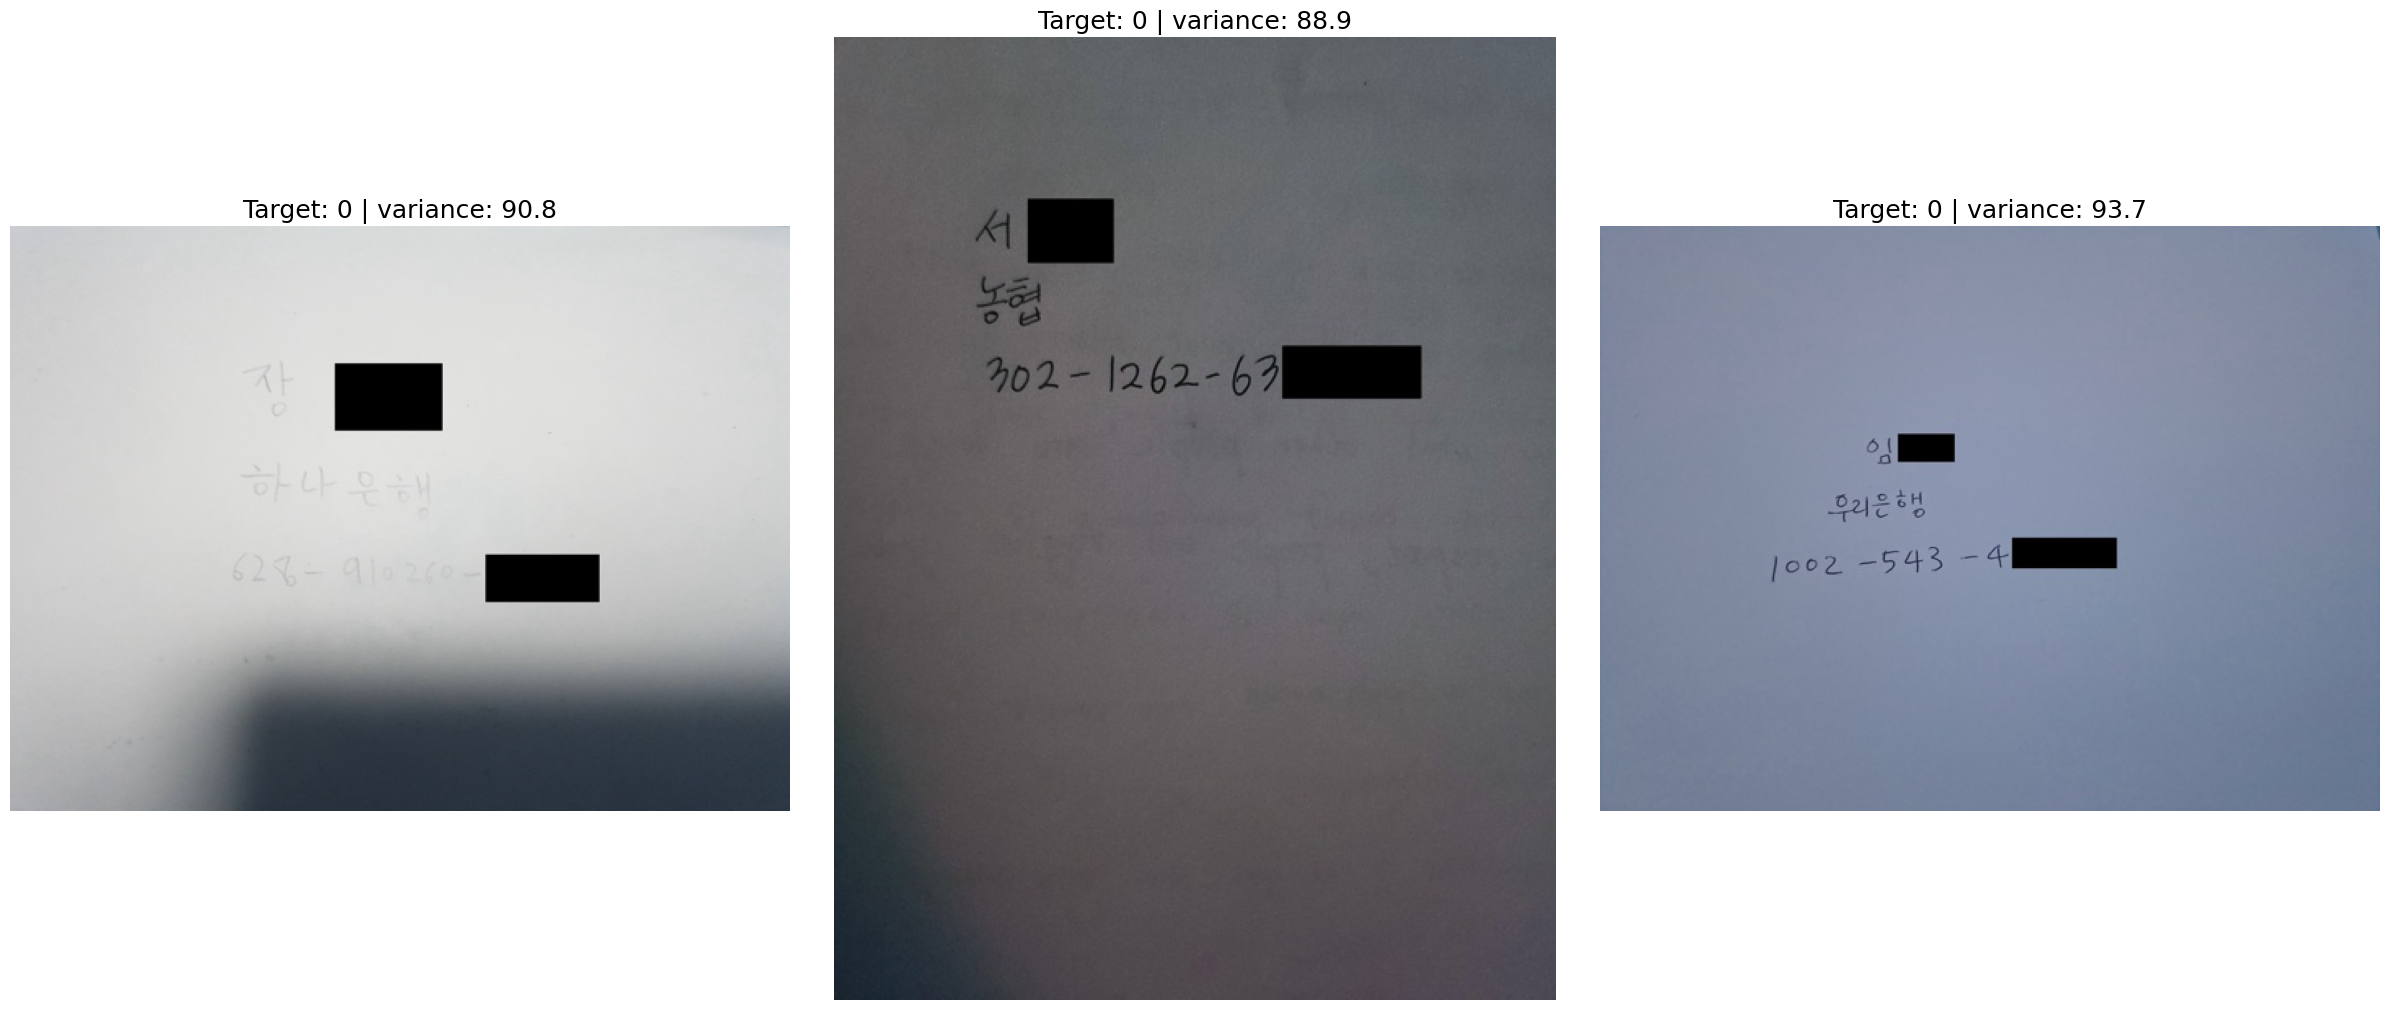

In [15]:
show_sample_image(blurry_samples, train_path, analysis_col="variance", n_samples=3)

- Masking Check

In [16]:
masking_stats = []

for idx, row in tqdm(train_label.iterrows(), total=len(train_label)):
    img_name = row.iloc[0]  # ID Column (이미지 파일명)
    img_path = os.path.join(train_path, img_name)
    
    img_cv = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_cv is None:
        print(f"이미지 로드 실패: {img_path}")
        continue
    
    black_pixels = np.sum(img_cv == 0)
    black_ratio = black_pixels / (img_cv.shape[0] * img_cv.shape[1])
    
    masking_stats.append({
        "ID": img_name,
        "target": row["target"],
        "black_ratio": black_ratio # 이미지 내 마스킹 비율
    })

masking = pd.DataFrame(masking_stats)
masking

100%|██████████| 1570/1570 [00:01<00:00, 1010.08it/s]


ID  target  black_ratio
0     002f99746285dfdd.jpg      16     0.003250
1     008ccd231e1fea5d.jpg      10     0.006696
2     008f5911bfda7695.jpg      10     0.006333
3     009235e4c9c07af5.jpg       4     0.018910
4     00b2f44967580c74.jpg      16     0.003976
...                    ...     ...          ...
1565  fed9e9ec4a77bc06.jpg       4     0.023773
1566  feeade617aa68c45.jpg       7     0.007608
1567  ff51dd281a8423f1.jpg      11     0.008964
1568  ff8a6a251ce51c95.jpg       5     0.134808
1569  ffc22136f958deb1.jpg       9     0.146145

[1570 rows x 3 columns]

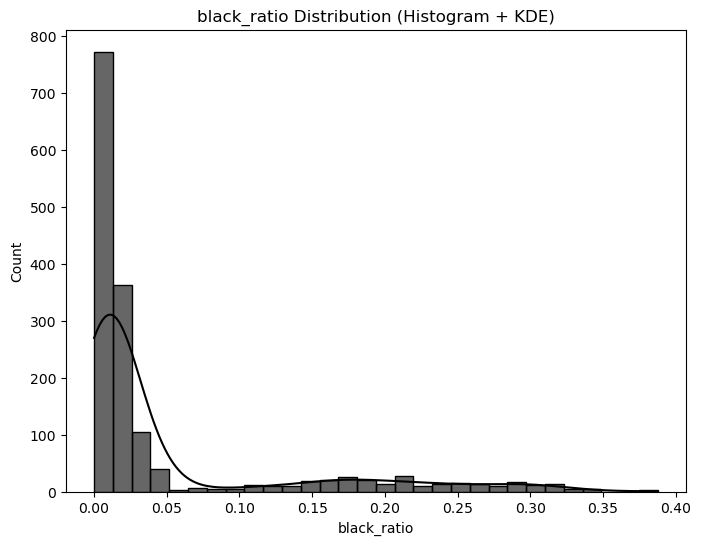

black_ratio
count  1570.000000
mean      0.048297
std       0.081454
min       0.000000
25%       0.005739
50%       0.013164
75%       0.029747
max       0.387713

In [17]:
hist_plot(df1=masking, col='black_ratio', color1='black')
masking[['black_ratio']].describe()

In [18]:
# masking 비율이 20% 이상 필터링
threshold = 0.2
masking_ratio_20 = masking[masking['black_ratio'] > threshold]
total_count = len(masking)
high_count = len(masking_ratio_20)
high_ratio = high_count / total_count * 100

print(f"총 데이터 개수: {total_count}")
print(f"{threshold*100:.0f}% 이상 마스킹된 데이터 개수: {high_count}")
print(f"{threshold*100:.0f}% 이상 마스킹된 비율: {high_ratio:.2f}%")

총 데이터 개수: 1570
20% 이상 마스킹된 데이터 개수: 145
20% 이상 마스킹된 비율: 9.24%


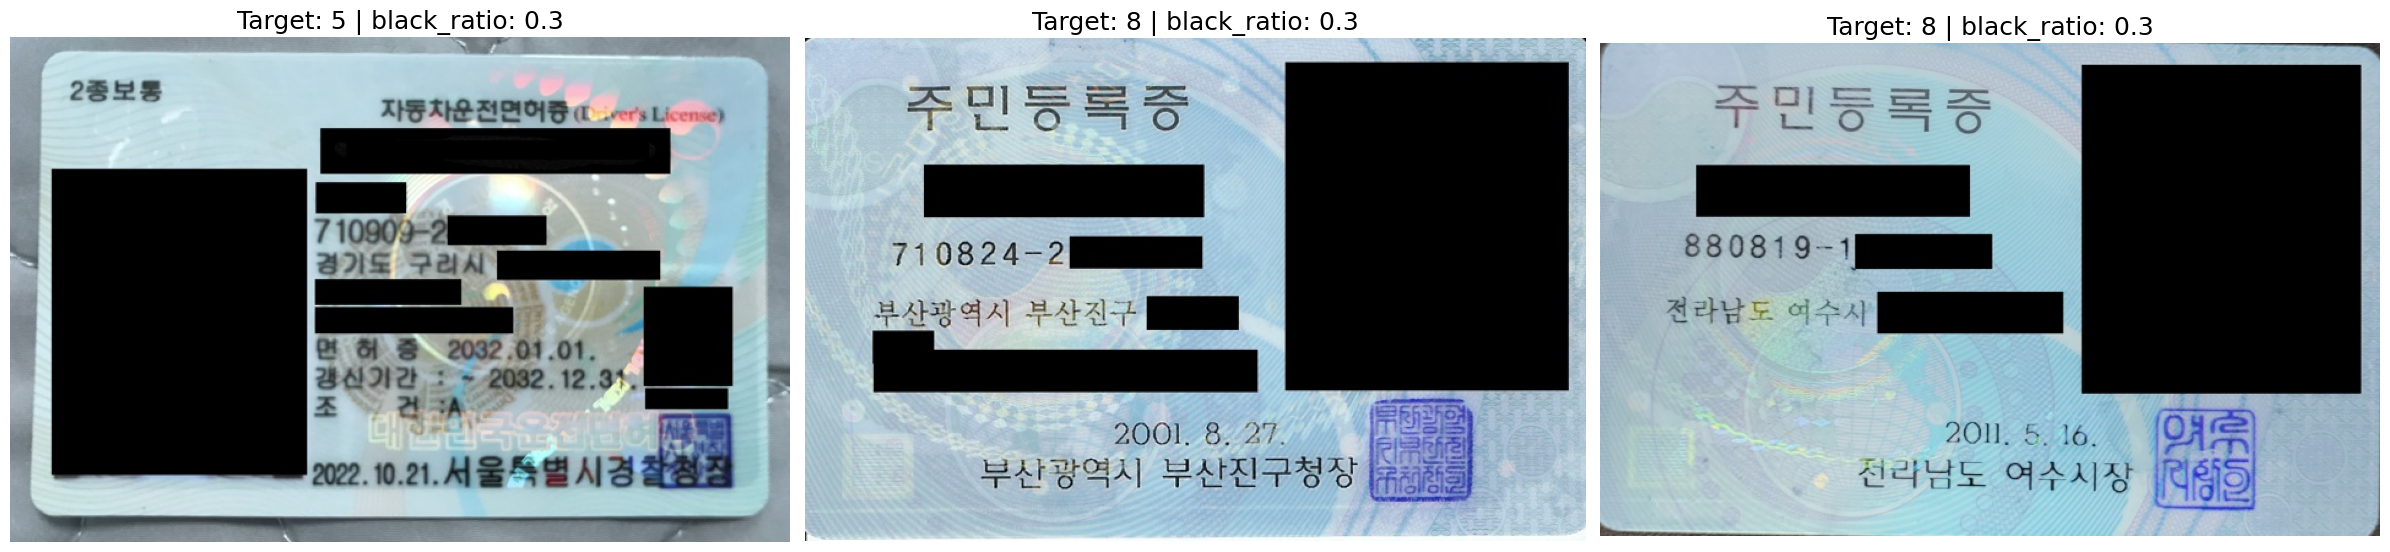

In [19]:
# 확인
show_sample_image(masking_ratio_20, train_path, analysis_col="black_ratio", n_samples=3) 

- 명도 Check

In [20]:
brightness_stats = []

for idx, row in tqdm(train_label.iterrows(), total=len(train_label)):
    img_name = row.iloc[0]  # ID Column
    img_path = os.path.join(train_path, img_name)
    
    img_cv = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_cv is None:
        print(f"이미지 로드 실패: {img_path}")
        continue
    
    mean_brightness = img_cv.mean()
    
    brightness_stats.append({
        "ID": img_name,
        "target": row["target"],
        "mean_brightness": mean_brightness # 값이 클수록 이미지가 밝음
    })

brightness = pd.DataFrame(brightness_stats)
brightness

100%|██████████| 1570/1570 [00:01<00:00, 948.77it/s]


ID  target  mean_brightness
0     002f99746285dfdd.jpg      16       112.679065
1     008ccd231e1fea5d.jpg      10       157.959196
2     008f5911bfda7695.jpg      10       160.815399
3     009235e4c9c07af5.jpg       4       145.531395
4     00b2f44967580c74.jpg      16       101.451001
...                    ...     ...              ...
1565  fed9e9ec4a77bc06.jpg       4       157.563780
1566  feeade617aa68c45.jpg       7       149.151452
1567  ff51dd281a8423f1.jpg      11       167.814478
1568  ff8a6a251ce51c95.jpg       5       188.081710
1569  ffc22136f958deb1.jpg       9       150.616337

[1570 rows x 3 columns]

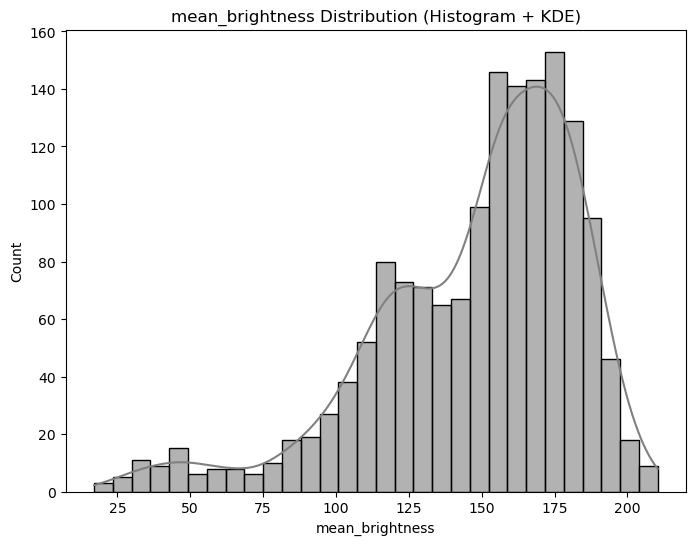

mean_brightness
count      1570.000000
mean        148.186849
std          35.400525
min          16.989584
25%         126.743481
50%         156.485003
75%         174.019782
max         210.390733

In [21]:
hist_plot(df1=brightness, col='mean_brightness', color1='gray')
brightness[['mean_brightness']].describe()

In [ ]:
# 밝기가 100 이하인 이미지 필터링
threshold = 100
brightness_100 = brightness[brightness['mean_brightness'] < threshold]
total_count = len(brightness)
high_count = len(brightness_100)
high_ratio = high_count / total_count * 100

print(f"총 데이터 개수: {total_count}")
print(f"밝기 {threshold:.0f} 이하 이미지 개수: {high_count}")
print(f"밝기 {threshold:.0f} 이하 이미지 비율: {high_ratio:.2f}%")

총 데이터 개수: 1570
밝기 100 이하 이미지 개수: 139
밝기 100 이하 이미지 비율: 8.85%


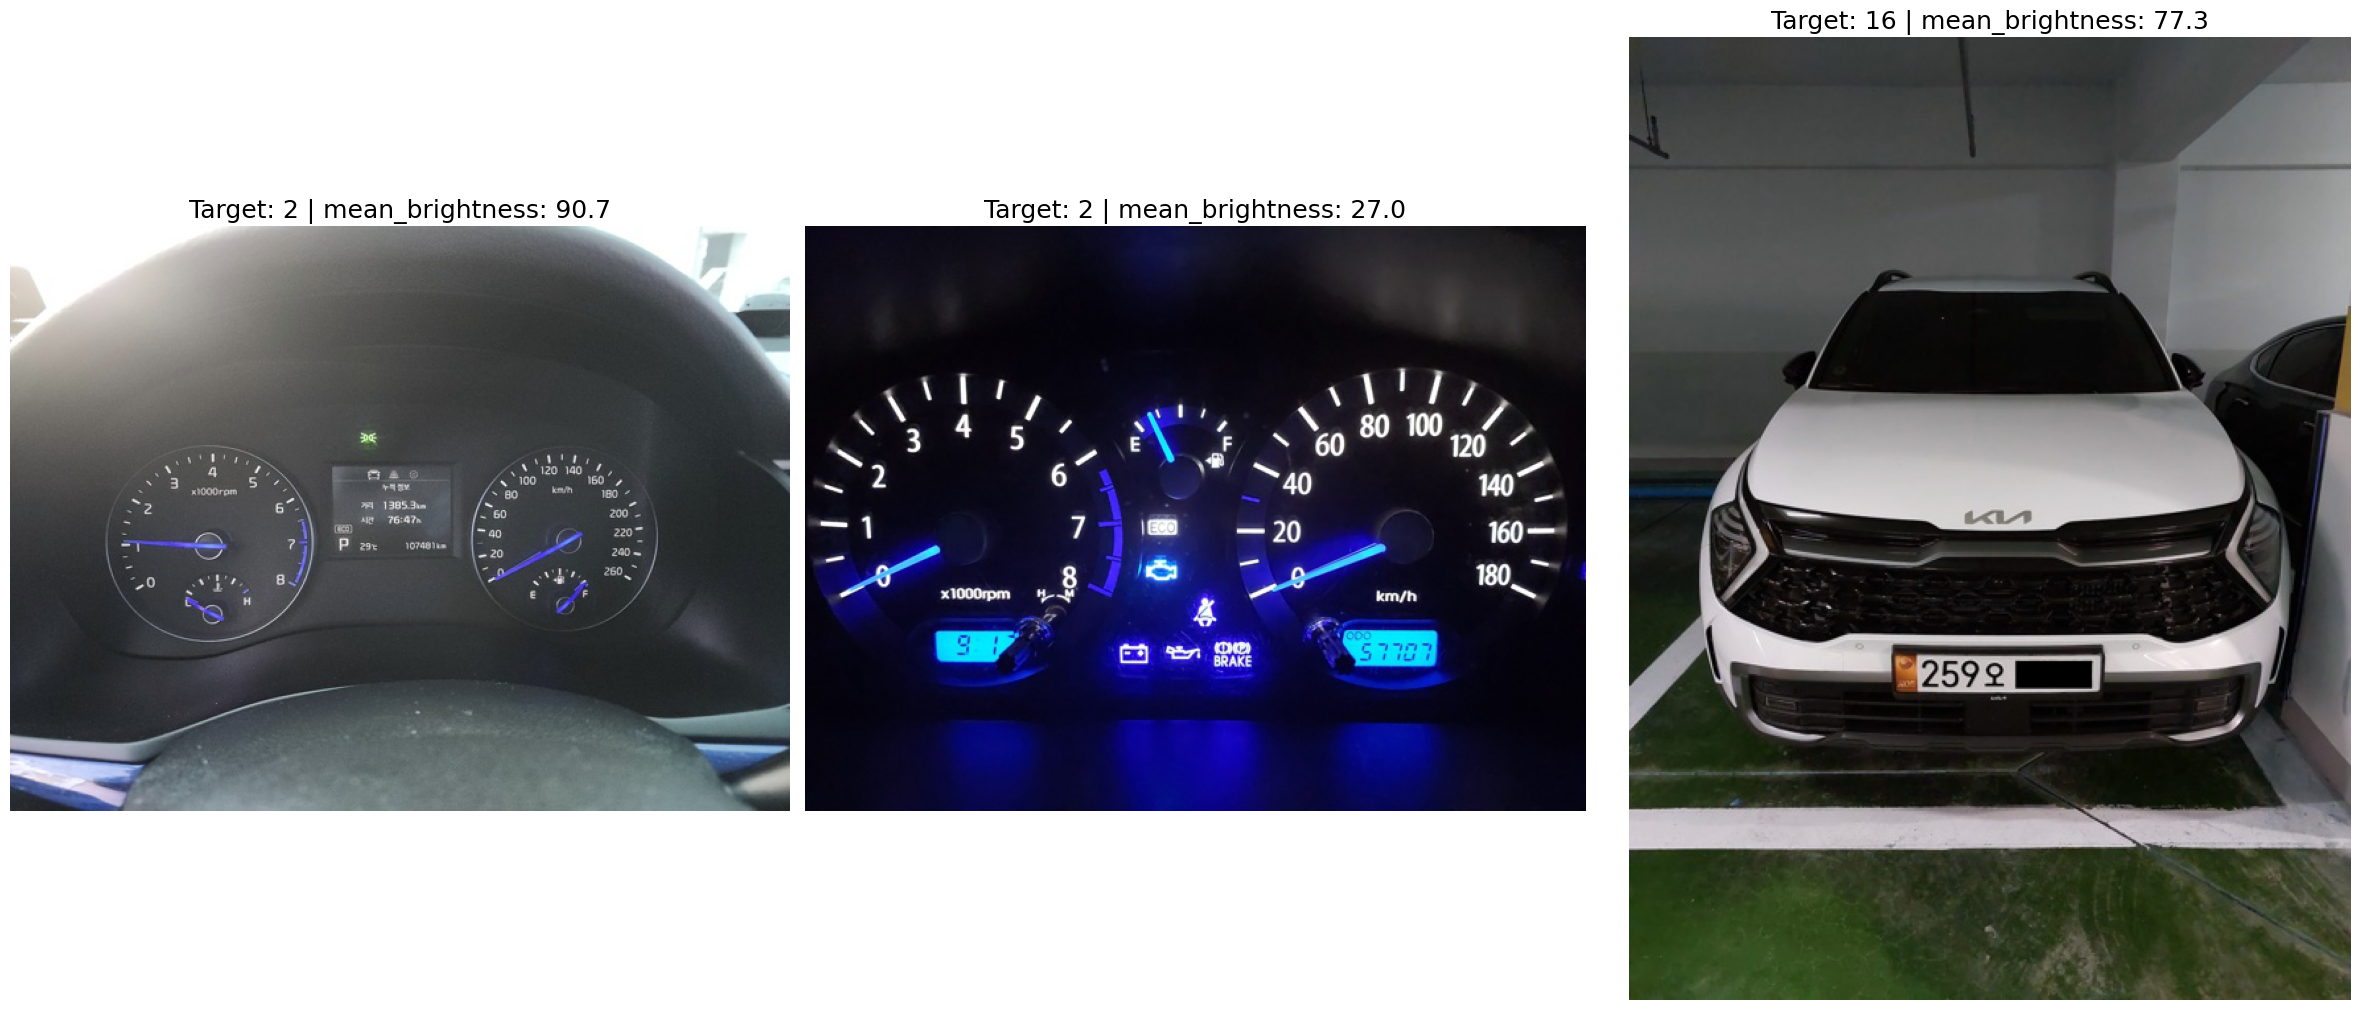

In [23]:
# 확인
show_sample_image(brightness_100, train_path, analysis_col="mean_brightness", n_samples=3) 

- Image size Check

In [24]:
resolution_stats = []

for idx, row in tqdm(train_label.iterrows(), total=len(train_label)):
    img_name = row['ID']  # ID 컬럼에서 이미지 파일명
    img_path = os.path.join(train_path, img_name)
    
    img_cv = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_cv is None:
        print(f"[로드 실패] {img_path}")
        continue
    
    height, width = img_cv.shape
    resolution_stats.append({
        "ID": img_name,
        "target": row["target"],
        "width": width,
        "height": height,
        "aspect_ratio": width / height
    })

resolution_df = pd.DataFrame(resolution_stats)
resolution_df

100%|██████████| 1570/1570 [00:01<00:00, 1145.03it/s]


ID  target  width  height  aspect_ratio
0     002f99746285dfdd.jpg      16    443     591      0.749577
1     008ccd231e1fea5d.jpg      10    443     591      0.749577
2     008f5911bfda7695.jpg      10    443     591      0.749577
3     009235e4c9c07af5.jpg       4    443     591      0.749577
4     00b2f44967580c74.jpg      16    443     591      0.749577
...                    ...     ...    ...     ...           ...
1565  fed9e9ec4a77bc06.jpg       4    443     591      0.749577
1566  feeade617aa68c45.jpg       7    443     591      0.749577
1567  ff51dd281a8423f1.jpg      11    591     443      1.334086
1568  ff8a6a251ce51c95.jpg       5    722     362      1.994475
1569  ffc22136f958deb1.jpg       9    590     443      1.331828

[1570 rows x 5 columns]

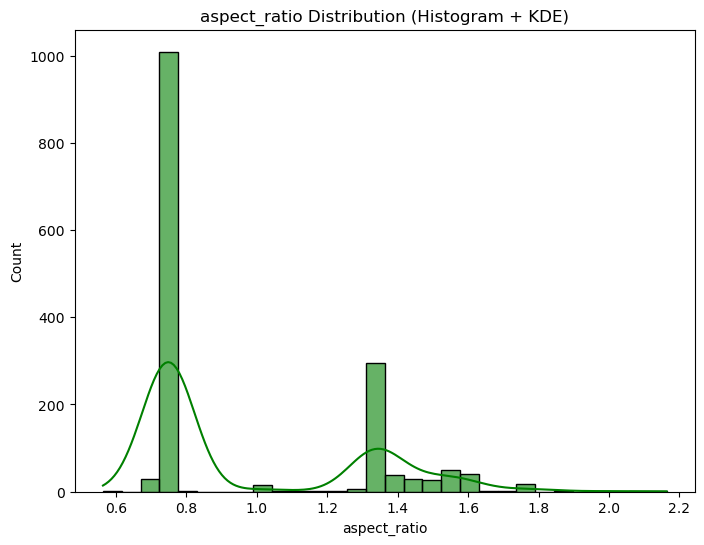

width       height  aspect_ratio
count  1570.000000  1570.000000   1570.000000
mean    497.613376   538.169427      0.970007
std      79.370316    76.074772      0.323053
min     384.000000   348.000000      0.563050
25%     443.000000   443.000000      0.749577
50%     443.000000   591.000000      0.749577
75%     591.000000   591.000000      1.334086
max     753.000000   682.000000      2.163793

In [25]:
hist_plot(resolution_df, col='aspect_ratio', color1='Green')
resolution_df[['width', 'height', 'aspect_ratio']].describe()

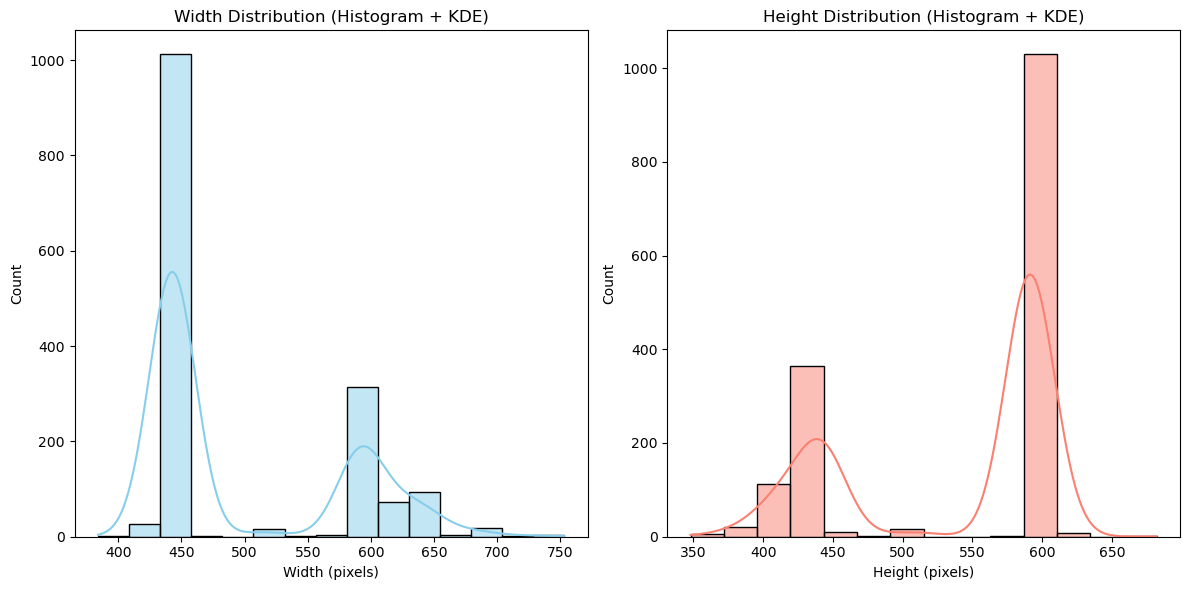

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Width
sns.histplot(resolution_df['width'], kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Width Distribution (Histogram + KDE)')
ax[0].set_xlabel('Width (pixels)')
ax[0].set_ylabel('Count')

# Height
sns.histplot(resolution_df['height'], kde=True, ax=ax[1], color='salmon')
ax[1].set_title('Height Distribution (Histogram + KDE)')
ax[1].set_xlabel('Height (pixels)')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

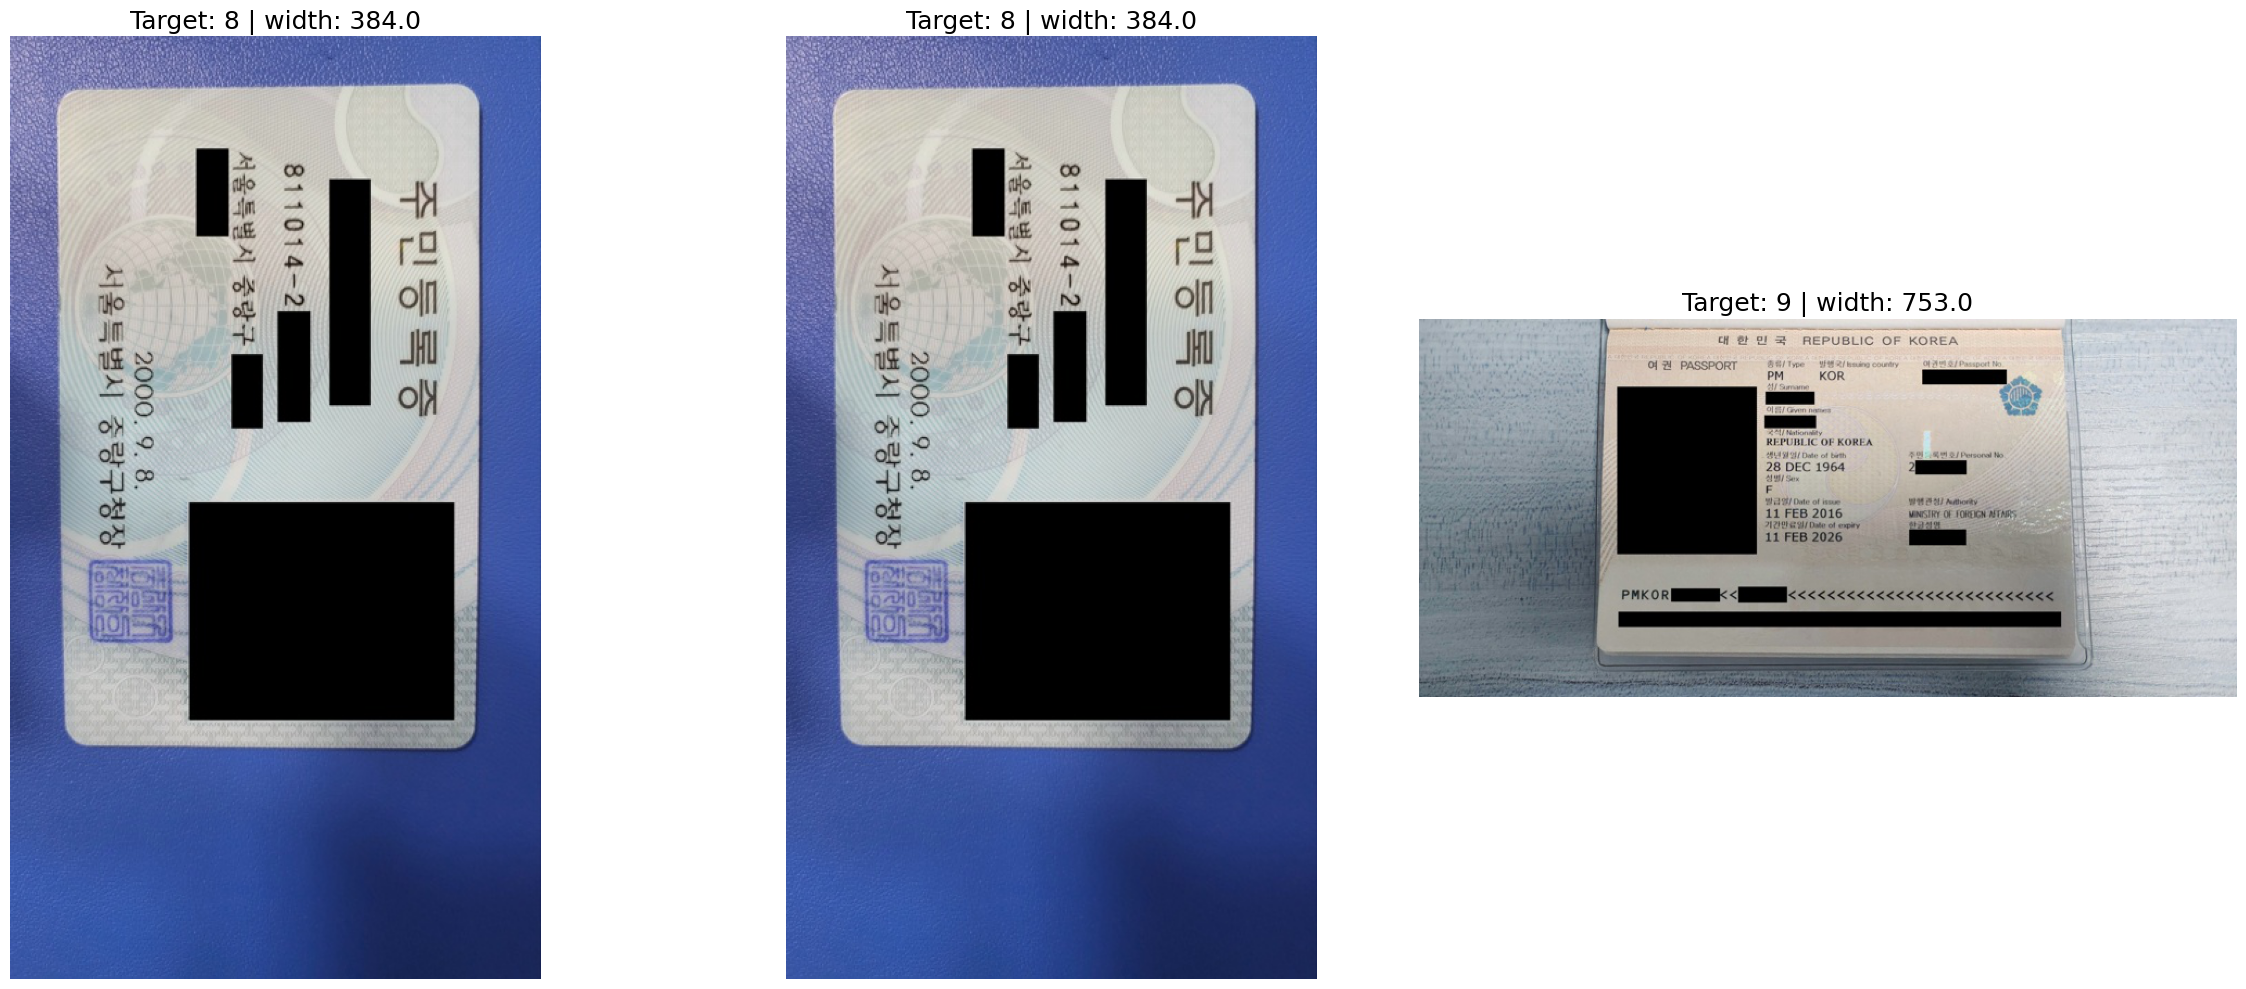

In [27]:
# 가장 작은 width 이미지
min_width_img = resolution_df.loc[resolution_df['width'].idxmin()]
# 가장 큰 width 이미지
max_width_img = resolution_df.loc[resolution_df['width'].idxmax()]
# 가장 작은 height 이미지
min_height_img = resolution_df.loc[resolution_df['height'].idxmin()]
# 가장 큰 height 이미지
max_height_img = resolution_df.loc[resolution_df['height'].idxmax()]

samples = pd.DataFrame([min_width_img, max_width_img, min_height_img, max_height_img])

show_sample_image(samples, train_path, analysis_col="width", n_samples=3)

#### Correlation

In [28]:
train_labels.head(3)

ID                  class_name  target
0  002f99746285dfdd.jpg  vehicle_registration_plate      16
1  008ccd231e1fea5d.jpg        payment_confirmation      10
2  008f5911bfda7695.jpg        payment_confirmation      10

In [29]:
train_df = pd.merge(train_labels, blur, on=['ID', 'target'], how='left')
train_df = pd.merge(train_df, masking, on=['ID', 'target'], how='left')
train_df = pd.merge(train_df, brightness, on=['ID', 'target'], how='left')
train_df = pd.merge(train_df, resolution_df, on=['ID', 'target'], how='left')
train_df = train_df[['ID', 'variance', 'black_ratio', 'mean_brightness', 
                     'width', 'height', 'aspect_ratio', 'class_name', 'target']]
train_df

ID     variance  black_ratio  mean_brightness  width  \
0     002f99746285dfdd.jpg  4461.719775     0.003250       112.679065    443   
1     008ccd231e1fea5d.jpg  1630.437757     0.006696       157.959196    443   
2     008f5911bfda7695.jpg  3522.353811     0.006333       160.815399    443   
3     009235e4c9c07af5.jpg  1140.816877     0.018910       145.531395    443   
4     00b2f44967580c74.jpg  1590.176746     0.003976       101.451001    443   
...                    ...          ...          ...              ...    ...   
1565  fed9e9ec4a77bc06.jpg  1478.417648     0.023773       157.563780    443   
1566  feeade617aa68c45.jpg  1054.485550     0.007608       149.151452    443   
1567  ff51dd281a8423f1.jpg  2019.669529     0.008964       167.814478    591   
1568  ff8a6a251ce51c95.jpg   941.559549     0.134808       188.081710    722   
1569  ffc22136f958deb1.jpg  2893.576158     0.146145       150.616337    590   

      height  aspect_ratio                      class_name  target  
0        591      0.749577      vehicle_registration_plate      16  
1        591      0.749577            payment_confirmation      10  
2        591      0.749577            payment_confirmation      10  
3        591      0.749577                       diagnosis       4  
4        591      0.749577      vehicle_registration_plate      16  
...      ...           ...                             ...     ...  
1565     591      0.749577                       diagnosis       4  
1566     591      0.749577  medical_outpatient_certificate       7  
1567     443      1.334086          pharmaceutical_receipt      11  
1568     362      1.994475                  driver_lisence       5  
1569     443      1.331828                        passport       9  

[1570 rows x 9 columns]

In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570 entries, 0 to 1569
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               1570 non-null   object 
 1   variance         1570 non-null   float64
 2   black_ratio      1570 non-null   float64
 3   mean_brightness  1570 non-null   float64
 4   width            1570 non-null   int64  
 5   height           1570 non-null   int64  
 6   aspect_ratio     1570 non-null   float64
 7   class_name       1570 non-null   object 
 8   target           1570 non-null   int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 110.5+ KB


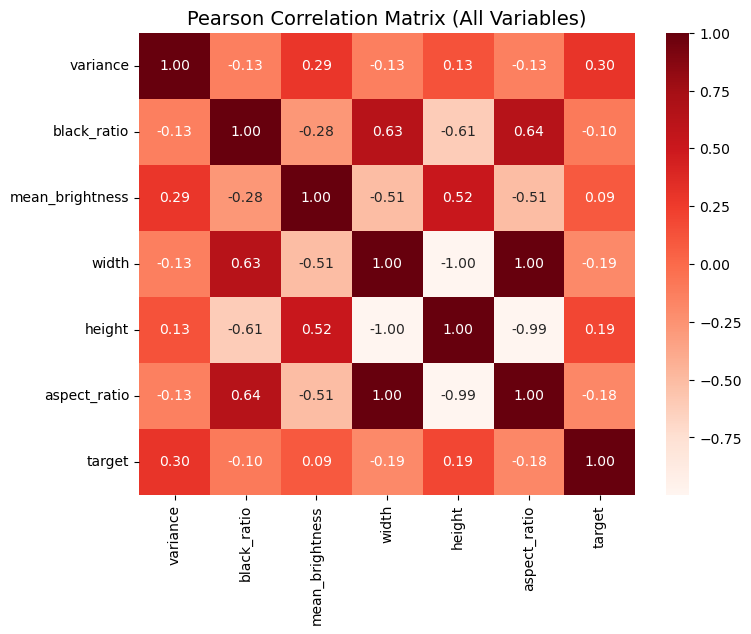

In [31]:
heat_map(df=train_df, figsize=(8, 6), cmap='Reds') # 타겟 변수와 상관계수